In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import numpy as np # linear algebra
import pandas as pd # dataframes
import matplotlib.pyplot as plt # General visualisations
import matplotlib.ticker as mtick # Axis visuals
import seaborn as sns # Statistical visualisations
from math import pi # Radar chart support
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix 

roc_auc_score
# Load data into pandas
df_stru = pd.read_csv("csv_building_structure.csv",
                     index_col = 'building_id')

# Plot styling
plt.style.use('ggplot')

In [67]:
df_stru.head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,1,9,288,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
120101000021,12,1207,120703,1,1,15,364,9,9,Flat,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
120101000031,12,1207,120703,1,1,20,384,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000041,12,1207,120703,1,1,20,312,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair
120101000051,12,1207,120703,1,1,30,308,9,9,Flat,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 1,Minor repair


In [68]:
display(df_stru.dtypes.value_counts())
df_stru.dtypes

int64     20
object    10
dtype: int64

district_id                                int64
vdcmun_id                                  int64
ward_id                                    int64
count_floors_pre_eq                        int64
count_floors_post_eq                       int64
age_building                               int64
plinth_area_sq_ft                          int64
height_ft_pre_eq                           int64
height_ft_post_eq                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_m

In [69]:
df_stru.shape

(762106, 30)

In [70]:
df_stru = df_stru.astype({'district_id': 'object', 'vdcmun_id': 'object', 'ward_id': 'object'})

In [71]:
# View missingness
df_temp = df_stru.isnull().sum().reset_index(name='count')
display(df_temp[df_temp['count'] > 0])

# Drop Rows with missing data
df_stru.dropna(inplace = True)

,index,count
14,position,1
15,plan_configuration,1
28,damage_grade,12
29,technical_solution_proposed,12


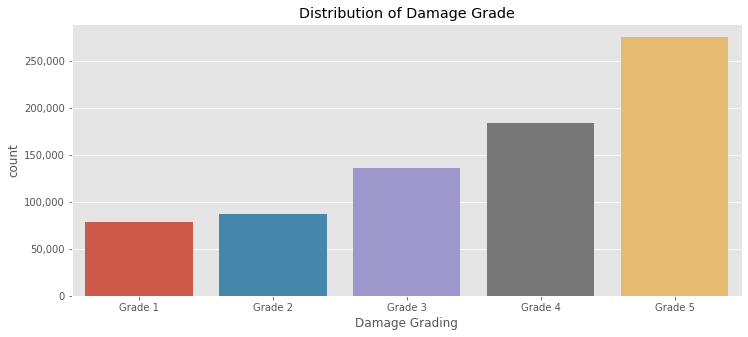

In [72]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='damage_grade', data=df_stru, order = ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4', 'Grade 5'])
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title("Distribution of Damage Grade")
plt.xlabel("Damage Grading")
plt.show()

In [73]:
# view Names
df_stru.select_dtypes(include=object).dtypes # Data types

district_id                    object
vdcmun_id                      object
ward_id                        object
land_surface_condition         object
foundation_type                object
roof_type                      object
ground_floor_type              object
other_floor_type               object
position                       object
plan_configuration             object
condition_post_eq              object
damage_grade                   object
technical_solution_proposed    object
dtype: object

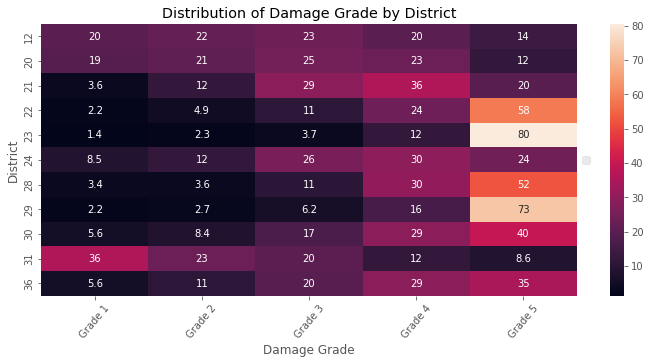

In [74]:
# Calculate counts
df_temp = df_stru.groupby(['district_id','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['district_id', 'damage_grade'])

# Calculate Proportion of grade
df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values='count', index=['district_id'], columns='damage_grade')

# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by District")
plt.xlabel("Damage Grade")
plt.ylabel("District")
plt.show()

# Clean up
del df_temp, ax

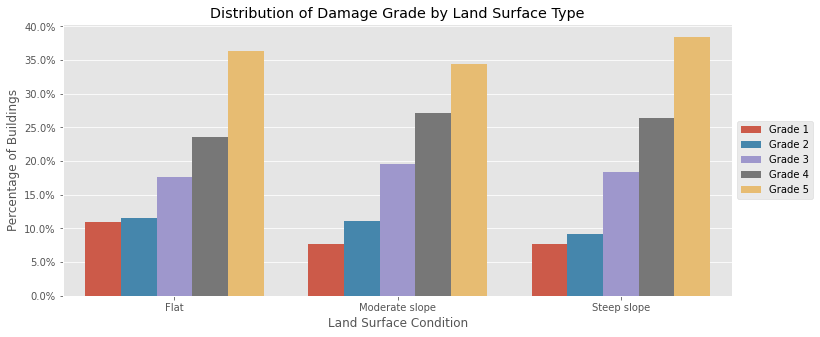

In [75]:
# Calculate counts
df_temp = df_stru.groupby(['land_surface_condition','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['land_surface_condition', 'damage_grade'])

# Calculate Proportion of grade
df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'land_surface_condition', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Land Surface Type")
plt.xlabel("Land Surface Condition")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

In [76]:
df_stru.foundation_type.value_counts()

Mud mortar-Stone/Brick    628705
Bamboo/Timber              57472
Cement-Stone/Brick         39245
RC                         32120
Other                       4552
Name: foundation_type, dtype: int64

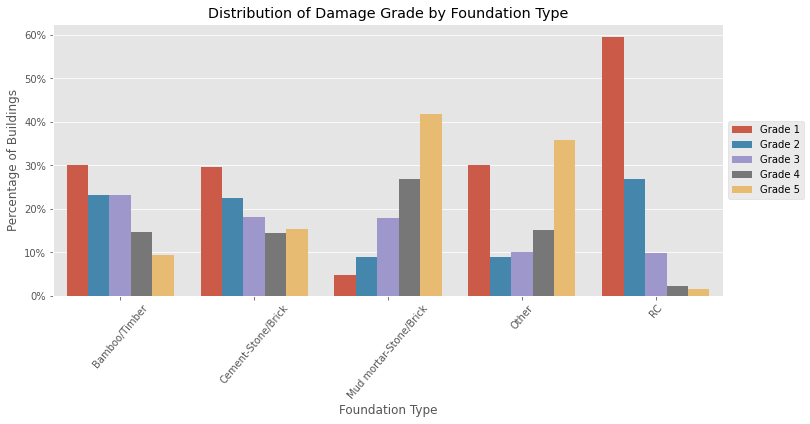

In [77]:
# Calculate counts
df_temp = df_stru.groupby(['foundation_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['foundation_type', 'damage_grade'])

# Calculate Proportion of grade
df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Plot chart
plt.figure(figsize=(12,5))
ax = sns.barplot(data = df_temp, 
                 x = 'foundation_type', 
                 y = 'count', 
                 hue = 'damage_grade')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Foundation Type")
plt.xlabel("Foundation Type")
plt.ylabel("Percentage of Buildings")
plt.show()

# Clean up
del df_temp, ax

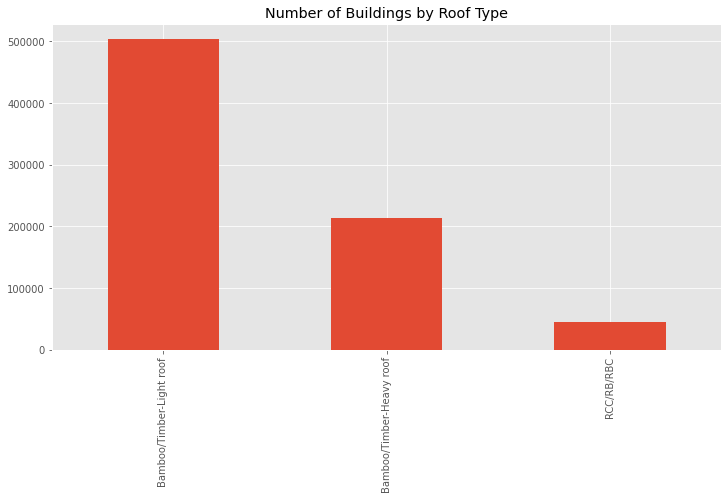

In [78]:
plt.figure(figsize = (12,6))
ax = df_stru.roof_type.value_counts().plot(kind = "bar")
plt.title("Number of Buildings by Roof Type")
plt.show()

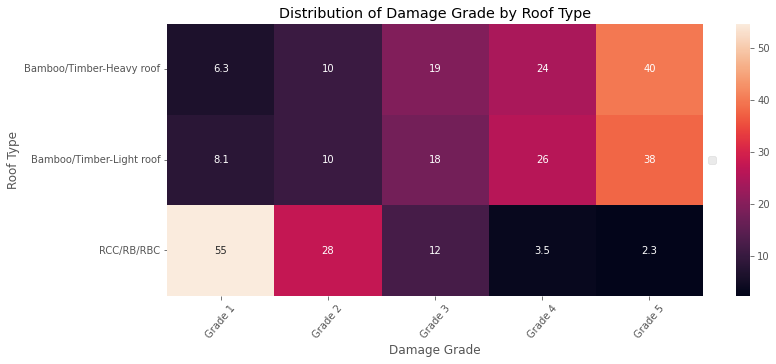

In [79]:
# Calculate counts
df_temp = df_stru.groupby(['roof_type','damage_grade']).size().reset_index(name='count')

# Set Index
df_temp = df_temp.set_index(['roof_type', 'damage_grade'])

# Calculate Proportion of grade
df_temp = df_temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

# Pivot table
df_temp = pd.pivot_table(df_temp, values='count', index=['roof_type'], columns='damage_grade')

# Plot char
plt.figure(figsize=(12,5))
ax = sns.heatmap(data = df_temp, annot = True )
plt.xticks(rotation = 50)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title("Distribution of Damage Grade by Roof Type")
plt.xlabel("Damage Grade")
plt.ylabel("Roof Type")
plt.show()

# Clean up
del df_temp, ax

In [80]:
# view Names
df_stru.select_dtypes(include=[float, int]).dtypes # Data types

count_floors_pre_eq                       int64
count_floors_post_eq                      int64
age_building                              int64
plinth_area_sq_ft                         int64
height_ft_pre_eq                          int64
height_ft_post_eq                         int64
has_superstructure_adobe_mud              int64
has_superstructure_mud_mortar_stone       int64
has_superstructure_stone_flag             int64
has_superstructure_cement_mortar_stone    int64
has_superstructure_mud_mortar_brick       int64
has_superstructure_cement_mortar_brick    int64
has_superstructure_timber                 int64
has_superstructure_bamboo                 int64
has_superstructure_rc_non_engineered      int64
has_superstructure_rc_engineered          int64
has_superstructure_other                  int64
dtype: object

In [81]:
# Describe the 
df_stru.describe().transpose().drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
count_floors_pre_eq,2.087787,0.655104,1.0,2.0,2.0,2.0,9.0
count_floors_post_eq,1.252050,1.063278,0.0,0.0,1.0,2.0,9.0
age_building,24.325031,65.034555,0.0,9.0,16.0,27.0,999.0
plinth_area_sq_ft,406.673668,226.780437,70.0,280.0,358.0,470.0,5000.0
height_ft_pre_eq,16.049424,5.493900,6.0,12.0,16.0,18.0,99.0
height_ft_post_eq,9.868785,8.574218,0.0,0.0,11.0,16.0,99.0
has_superstructure_adobe_mud,0.042402,0.201504,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,0.800269,0.399799,0.0,1.0,1.0,1.0,1.0
has_superstructure_stone_flag,0.035122,0.184087,0.0,0.0,0.0,0.0,1.0
has_superstructure_cement_mortar_stone,0.015816,0.124762,0.0,0.0,0.0,0.0,1.0


In [ ]:
df_stru.drop(['net_rooms', 'net_height'], axis = 1, inplace = True) 

In [64]:
display(df_stru.columns)

Index(['district_id', 'vdcmun_id', 'ward_id', 'count_floors_pre_eq',
       'count_floors_post_eq', 'age_building', 'plinth_area_sq_ft',
       'height_ft_pre_eq', 'height_ft_post_eq', 'land_surface_condition',
       'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type',
       'position', 'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [82]:
# Create training and testing data
x_train, x_test, y_train, y_test = train_test_split(df_stru.drop('damage_grade', axis = 1), 
                                                    df_stru['damage_grade'],
                                                    test_size = 0.2, 
                                                    random_state = 1989, 
                                                    stratify = df_stru['damage_grade'],
                                                    shuffle=True)


# Visualise proportions on train and test
pd.merge(y_train.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="train"),
         y_test.reset_index(name="damage_grade").damage_grade.value_counts(normalize = True).reset_index(name="test"),
         on = "index",
         how = "left")

,index,train,test
0,Grade 5,0.361853,0.361851
1,Grade 4,0.241235,0.241236
2,Grade 3,0.178995,0.179000
3,Grade 2,0.114497,0.114494
4,Grade 1,0.103419,0.103419


In [83]:
# ------------ Target Processing ------------

# Target Variable Transformer
preprocessor_tar = LabelEncoder()
y_train = preprocessor_tar.fit_transform(y_train)
y_test = preprocessor_tar.fit_transform(y_test)

# Visualise Counts
pd.DataFrame(y_train).value_counts(normalize = True)

# Clean objects
del preprocessor_tar

In [84]:
# Print x train shape before processing
print("Before preprocessing there were {} rows and {} columns".format(*x_train.shape))

# ------------ Predictor Processing ------------
# Identify columns
fts_cvt_obj = ['district_id', 'vdcmun_id', 'ward_id']
fts_outlier = ['age_building']
fts_cat = df_stru.drop(fts_cvt_obj, axis = 1).select_dtypes(include=['object']).drop('damage_grade', axis = 1).columns
fts_num = df_stru.select_dtypes(np.number).columns

# Convert to object Transformer
def covert_to_object(x):
    '''Converts a column to object'''
    return pd.DataFrame(x).astype(object)
trans_to_object = Pipeline(steps = [('convert_to_object', FunctionTransformer(covert_to_object))])

# Outlier Restriction
trans_outlier = Pipeline(steps = [('Outlier_scaler', RobustScaler(quantile_range = (0,0.9)))])

# Categorical Transformer
trans_cat = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Numerical Transformer
trans_num = Pipeline(steps = [('scaler', StandardScaler()),
                              ('MinMax', MinMaxScaler())])

# Zero or Near Zero variance
trans_nzv = Pipeline(steps = [('nzv', VarianceThreshold(threshold = 0.01))])

# Create a single Preprocessing step for predictors
preprocessor_preds = ColumnTransformer(
    transformers=[
        ('convert_to_object', trans_to_object, fts_cvt_obj), # Convert data types
        ('Outlier', trans_outlier, fts_outlier), # Outlier treatment 
        ('num', trans_num, fts_num), # Centre and scale
        ('cat', trans_cat, fts_cat), # One Hot encode
        ('nzv', trans_nzv,[]) # One Hot encode
    ])
      
# Apply the transformations to both train and test
x_train = preprocessor_preds.fit_transform(x_train)
x_test = preprocessor_preds.fit_transform(x_test)   

# Print x train shape before processing
print("After preprocessing there are {} rows and {} columns".format(*x_train.shape))

# Clean objects
del fts_cvt_obj, fts_outlier, fts_cat, fts_num, covert_to_object, trans_to_object, trans_outlier, trans_cat, trans_num, trans_nzv

Before preprocessing there were 609675 rows and 29 columns
After preprocessing there are 609675 rows and 67 columns


In [87]:
# Store the Kfold object
kfold = KFold(n_splits=5, random_state=1989, shuffle = True)

In [93]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 4.6 MB/s eta 0:00:00


<ipython-input-94-e9032cb496fd>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  con_mat = con_mat / con_mat.astype(np.float).sum(axis=1)


Test Accuracy of random forest Model:  89.7 %

Train Accuracy of random forest Model:  99.82 %

Mean Squared Error (MSE):  0.3401


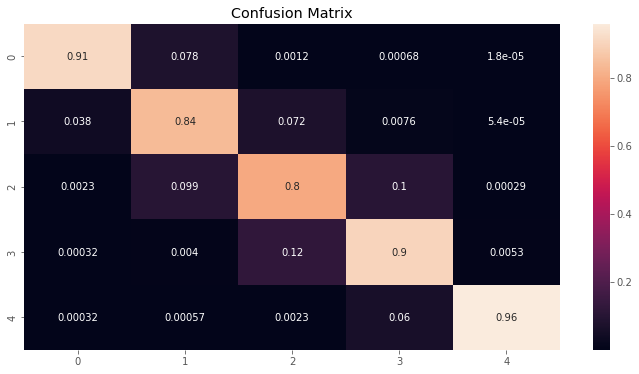

In [94]:
# Build the random forest on the full training data
rf = RandomForestClassifier() # instance
rf.fit(x_train, y_train) # fit model
y_pred = rf.predict(x_test) # predict on test

# Calculate confusion matrix
con_mat = confusion_matrix(y_test, y_pred)
con_mat = con_mat / con_mat.astype(np.float).sum(axis=1)


print('Test Accuracy of random forest Model: ',round(100*rf.score(x_test, y_test),2),'%')
print('')
print('Train Accuracy of random forest Model: ',round(100*rf.score(x_train, y_train),2),'%')
print('')

# Evaluate model

print('Mean Squared Error (MSE): ',round(np.sqrt(mean_squared_error(y_test,y_pred)),4))


# Plot Model
plt.figure(figsize = (12,6))
ax = sns.heatmap(con_mat, annot = True)
plt.title("Confusion Matrix")
plt.show()

y_test_data = pd.DataFrame(y_test)
writer = pd.ExcelWriter("y-test-RF.xlsx", engine='xlsxwriter')
y_test_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()

y_pred_data = pd.DataFrame(y_pred)
writer = pd.ExcelWriter("y_pred_RF.xlsx", engine='xlsxwriter')
y_pred_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()

In [95]:
#ElacticNet Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
reg=ElasticNet(alpha=0.001,l1_ratio=1,max_iter=1000000,tol=0.01)
reg.fit(x_train, y_train)
print('Test Accuracy of ElasticNet Model: ',round(100*reg.score(x_test, y_test),2),'%')
print('')
print('Train Accuracy of ElasticNet Model: ',round(100*reg.score(x_train, y_train),2),'%')
print('')
y_pred=reg.predict(x_test)

print('Mean Squared Error (MSE): ',round(np.sqrt(mean_squared_error(y_test,y_pred)),4))


y_pred_data = pd.DataFrame(y_pred)
writer = pd.ExcelWriter("y_pred_Elactic.xlsx", engine='xlsxwriter')
y_pred_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()

Test Accuracy of ElasticNet Model:  92.57 %

Train Accuracy of ElasticNet Model:  92.68 %

Mean Squared Error (MSE):  0.366


In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
reg=DecisionTreeRegressor()
reg.fit(x_train, y_train)
print('Test Accuracy of DecisionTree Regression: ',round(100*reg.score(x_test, y_test),2),'%')
print('')
print('Train Accuracy of DecisionTree Regression:',round(100*reg.score(x_train, y_train),2),'%')
print('')
y_pred=reg.predict(x_test)
print('Mean Squared Error (MSE): ',round(np.sqrt(mean_squared_error(y_test,y_pred)),4))


y_pred_data = pd.DataFrame(y_pred)
writer = pd.ExcelWriter("y_pred_DT.xlsx", engine='xlsxwriter')
y_pred_data.to_excel(writer,sheet_name = "sheet1_actual_data", index=False)
writer.save()

Test Accuracy of DecisionTree Regression:  90.86 %

Train Accuracy of DecisionTree Regression: 99.94 %

Mean Squared Error (MSE):  0.4058
